# House Price Predict
### preprocessing 
>* 결측치 파악 
>* 이상치 제거
>* scaling

### Model
>* MLP Regression ( 3 hidden layer , each hidden unit 250,700,1000, 600)

In [19]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler ,normalize
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [21]:
# train 파일 불러오기
df = pd.read_csv('train.csv')

In [22]:
#결측 데이터가 많은 column 순으로 데이터 확인
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [23]:
#sale price 와 상관관계가 높은 순서 출력 numeric 한  column
#  1. data cleaning 
#  2. sale price와  상관관계 높은 20개 분석하여  이상치 제거
corrmat = df.corr()
cols = corrmat.nlargest(40, 'SalePrice')['SalePrice'].index
print(cols)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt',
       'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1',
       'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
       'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch',
       'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
       'MiscVal', 'Id', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MSSubClass',
       'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')


In [24]:
# object 형식의 column 확인
print(df.select_dtypes(include=['object']).columns.values)

['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinish' 'GarageQual' 'GarageCond' 'PavedDrive'
 'PoolQC' 'Fence' 'MiscFeature' 'SaleType' 'SaleCondition']


## Null 값이 많은 순서대로 Data handling
>* 범주형 연속형 구분지어서 handling

In [25]:
# PoolQC handling
data = pd.concat([df['SalePrice'], df['PoolQC']], axis=1)


df['PoolQC'] = df['PoolQC'].replace('Ex', 'Ex')
df['PoolQC'] = df['PoolQC'].replace('Fa','GF')
df['PoolQC'] = df['PoolQC'].replace('Gd','GF')
df.loc[df.SalePrice >= 300000,'PoolQC'] = 'Ex'
df.loc[df.SalePrice < 300000,'PoolQC'] = 'GF'

df['PoolQC'].head()

0    GF
1    GF
2    GF
3    GF
4    GF
Name: PoolQC, dtype: object

count       54
unique       4
top       Shed
freq        49
Name: MiscFeature, dtype: object

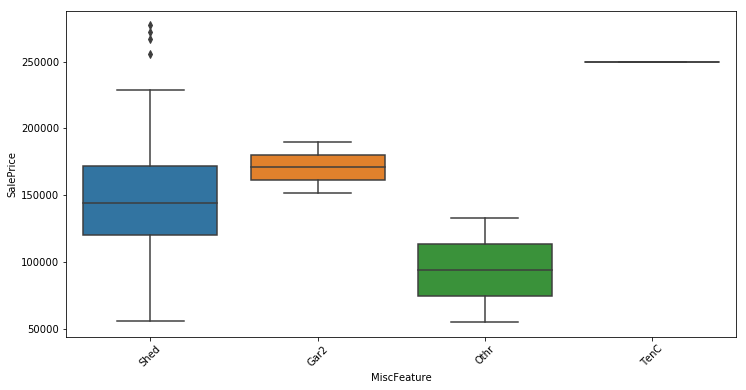

In [26]:
#MiscFeature handling
#MiscFeature 가 TenC 일 때 sale price 가 높다. 
#Shed Gar2 는 묶어서 Shed_Gar2 로 바꾸어 주고
#결측치는 가격이 250000 일 때 TenC , 140000 이하일 때 Othr

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'MiscFeature', y = 'SalePrice',  data = df)
xt = plt.xticks(rotation=45)

df.MiscFeature.describe()

In [27]:
df.loc[df.SalePrice >= 200000,'MiscFeature'] = 'TenC'

df.loc[df.SalePrice < 200000 ,'MiscFeature'] =  'Shed_Gar2'

df.loc[df.SalePrice < 140000,'MiscFeature'] = 'Othr'
df.MiscFeature.head()

0         TenC
1    Shed_Gar2
2         TenC
3    Shed_Gar2
4         TenC
Name: MiscFeature, dtype: object

count          1460
unique            3
top       Shed_Gar2
freq            536
Name: MiscFeature, dtype: object

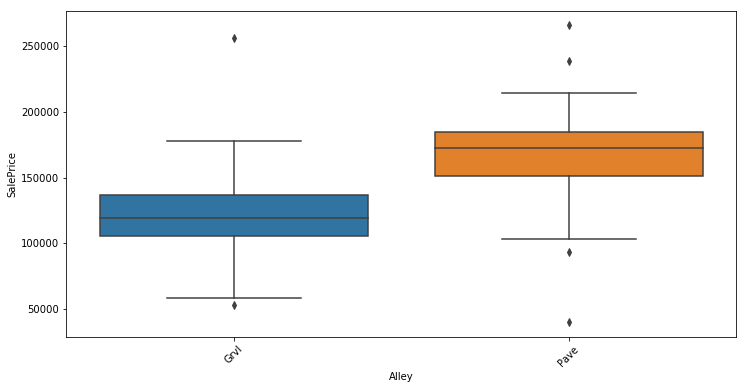

In [28]:
#Alley handling
# sale price 150000 이상이면 Pave , else Grvl 로 missing data 채워줌
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Alley', y = 'SalePrice',  data = df)
xt = plt.xticks(rotation=45)

df.MiscFeature.describe()

In [29]:
df.loc[df.SalePrice >= 150000,'Alley'] = 'Pave'

df.loc[df.SalePrice < 150000 ,'Alley'] =  'Grvl'

df.Alley.head()

0    Pave
1    Pave
2    Pave
3    Grvl
4    Pave
Name: Alley, dtype: object

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

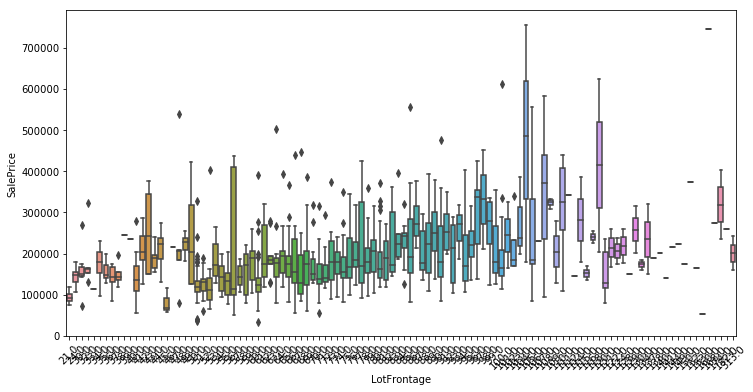

In [30]:
#LotFrontage handling
# LotFrontage 와 가격의 관계를 파악하기 힘들다. 
# 따라서 LotFrontage 와 상관관계가 가장 높은 column 을 찾아서 결측치를 채운다.
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'LotFrontage', y = 'SalePrice',  data = df)
xt = plt.xticks(rotation=45)

df.LotFrontage.describe()

In [32]:
#LotFrontage 와 상관관계가 가장 높은 column 은 1stFlrSF
cols = corrmat.nlargest(40, 'LotFrontage')['LotFrontage'].index
print(cols)

df['1stFlrSF'].describe()

Index(['LotFrontage', '1stFlrSF', 'LotArea', 'GrLivArea', 'TotalBsmtSF',
       'TotRmsAbvGrd', 'SalePrice', 'GarageArea', 'GarageCars', 'Fireplaces',
       'BedroomAbvGr', 'OverallQual', 'BsmtFinSF1', 'PoolArea', 'FullBath',
       'MasVnrArea', 'OpenPorchSF', 'BsmtUnfSF', 'YearBuilt', 'BsmtFullBath',
       'YearRemodAdd', 'WoodDeckSF', '2ndFlrSF', 'GarageYrBlt', '3SsnPorch',
       'HalfBath', 'BsmtFinSF2', 'ScreenPorch', 'LowQualFinSF', 'MoSold',
       'EnclosedPorch', 'YrSold', 'MiscVal', 'KitchenAbvGr', 'BsmtHalfBath',
       'Id', 'OverallCond', 'MSSubClass'],
      dtype='object')


count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

In [33]:
# 두 column 의 scale을 맞춰주고 결측치를 채운다.
df['1stFlrSF'] = (df['1stFlrSF'] - df['1stFlrSF'].mean()) / (df['1stFlrSF'].max() - df['1stFlrSF'].min())
df['LotFrontage'] = (df['LotFrontage'] - df['LotFrontage'].mean()) / (df['LotFrontage'].max() - df['LotFrontage'].min())

df['LotFrontage'] = df['LotFrontage'] .fillna(df['1stFlrSF'])
df['LotFrontage'].head()

0   -0.017294
1    0.034075
2   -0.007020
3   -0.034418
4    0.047774
Name: LotFrontage, dtype: float64

In [34]:
#Garage에 대한 null 값은 집에 garage가 없는 경우
#GarageCond  -범주형
#GarageType  - 범주형
#GarageYrBlt  -연속형
#GarageFinish - 범주형
#GarageQual   -범주형
#이 5가지 column이 한 set로 묶인다. 결측치를 새로운 value로 채운다.

df['GarageCond'] = df['GarageCond'].fillna('No')
df['GarageType'] = df['GarageType'].fillna('No')
df['GarageFinish'] = df['GarageFinish'].fillna('No')
df['GarageQual'] = df['GarageQual'].fillna('No')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [35]:
#BsmtExposure
#BsmtFinType2
#BsmtFinType1
#BsmtCond
#BsmtQual
#이 5가지 column이 한 set로 묶인다. 결측치를 새로운 value로 채운다.
df['BsmtExposure'] = df['BsmtExposure'].fillna('dont')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('dont')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('dont')
df['BsmtCond'] = df['BsmtCond'].fillna('dont')
df['BsmtQual'] = df['BsmtQual'].fillna('dont')



In [36]:
# Fence 의 경우 price와 상관관계가 적고 결측치가 90% 를 넘기 때문에 drop 시킴
# FireplaceQu 의 경우 Fireplace 으로 설명되어 질 수 있기 때문에 drop 시킴
df = df.drop(['Fence','Id','FireplaceQu'],axis=1)

In [37]:
df = df.dropna()
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,-0.017294,8450,Pave,Pave,Reg,Lvl,AllPub,Inside,...,0,0,GF,TenC,0,2,2008,WD,Normal,208500
1,20,RL,0.034075,9600,Pave,Pave,Reg,Lvl,AllPub,FR2,...,0,0,GF,Shed_Gar2,0,5,2007,WD,Normal,181500
2,60,RL,-0.007020,11250,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,0,GF,TenC,0,9,2008,WD,Normal,223500
3,70,RL,-0.034418,9550,Pave,Grvl,IR1,Lvl,AllPub,Corner,...,0,0,GF,Shed_Gar2,0,2,2006,WD,Abnorml,140000
4,60,RL,0.047774,14260,Pave,Pave,IR1,Lvl,AllPub,FR2,...,0,0,GF,TenC,0,12,2008,WD,Normal,250000


#### 이상치 제거
* 그래프 시각화

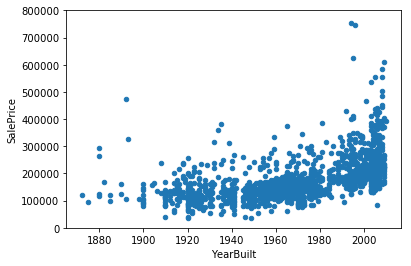

In [38]:
#시각화

var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)

#data[data['YearBuilt'] < 1900].sort_values(['SalePrice'])

#ylim 은 y 축 
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [39]:
#이상치 제거
df = df.drop([523])
df = df.drop([1298])
df = df.drop([457])
df = df.drop([1182])
df = df.drop([691])
df = df.drop([185])
df = df.drop([1250])
df = df.drop([1373])
df = df.drop([1044])
df =df.drop([332])
df=df.drop([496])
df=df.drop([53])


In [40]:
#one-hot encoding
df = pd.get_dummies(df)


In [41]:
#scaling

y_data = df['SalePrice']
min_max_scaler_y = preprocessing.MinMaxScaler()
y_data = min_max_scaler_y.fit_transform(y_data)


x_data = df.drop(['SalePrice'],axis=1)
min_max_scaler = preprocessing.MinMaxScaler()
x_data = min_max_scaler.fit_transform(x_data)


In [42]:
print(y_data) #1457
print(x_data) #1457 rows 220 cloumn

[ 0.29418743  0.24843247  0.31960685 ...,  0.39247585  0.18170649
  0.19081512]
[[ 0.23529412  0.15068493  0.0334198  ...,  0.          1.          0.        ]
 [ 0.          0.20205479  0.03879502 ...,  0.          1.          0.        ]
 [ 0.23529412  0.1609589   0.04650728 ...,  0.          1.          0.        ]
 ..., 
 [ 0.29411765  0.15410959  0.03618687 ...,  0.          1.          0.        ]
 [ 0.          0.1609589   0.03934189 ...,  0.          1.          0.        ]
 [ 0.          0.18493151  0.04037019 ...,  0.          1.          0.        ]]


In [43]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.ensemble import VotingClassifier


#### model 설정
* LinearRegression 의 경우 R : 95.3
* RANSAC 의 경우 R : 95.7

In [44]:
# MLPRegression
# R 값을 올리는 것에 중점을 두어서 오버피팅 문제는 생략하였습니다..

regr =MLPRegressor(
    hidden_layer_sizes=(250,700,1000,600),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.00025, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
regr.fit(x_data,y_data)

y_true = y_data
y_pred = regr.predict(x_data)

RMSE = (mean_squared_error(y_true, y_pred))**0.5
MSE = mean_squared_error(y_true, y_pred)
MAE = mean_absolute_error(y_true,y_pred)

R = r2_score(y_true, y_pred)  
print('MAE : ' , MAE , '\nMSE :',MSE, '\nRMSE : ',RMSE , '\nR :',R)
       

MAE :  0.0115331638537 
MSE : 0.000276239875001 
RMSE :  0.016620465547 
R : 0.983048611712


In [46]:
regr = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
regr.fit(x_data, y_data)

y_true = y_data
y_pred = regr.predict(x_data)

RMSE = (mean_squared_error(y_true, y_pred))**0.5
MSE = mean_squared_error(y_true, y_pred)
MAE = mean_absolute_error(y_true,y_pred)

R = r2_score(y_true, y_pred)  
print('MAE : ' , MAE , '\nMSE :',MSE, '\nRMSE : ',RMSE , '\nR :',R)
       

MAE :  0.0179041461925 
MSE : 0.000748617110705 
RMSE :  0.0273608682374 
R : 0.954061305153
